In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import random

import os

In [3]:
class config:
    seed = 42
    device = "cuda:0"    
        
    lr = 1e-3
    epochs = 25
    batch_size = 32
    num_workers = 4
    train_5_folds = True

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(config.seed)

In [4]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

device

device(type='cuda')

In [5]:
transform  = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [6]:
trainset = torchvision.datasets.CIFAR10(root='/data',
                                        train=True,
                                        download=True,
                                        transform=transform)

vaildset = torchvision.datasets.CIFAR10(root='/data',
                                        train=False,
                                        download=True,
                                        transform=transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified


In [7]:
testset = torchvision.datasets.ImageFolder(root = "/content/drive/MyDrive/share/images/Statistical_Deep_Image",
                                           transform = transform)

In [ ]:


trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [8]:
train_loader = DataLoader(trainset,
                          batch_size = 32,
                          shuffle=True,
                          num_workers=2)

vaild_loader = DataLoader(vaildset,
                          batch_size = 64,
                          shuffle=True,
                          num_workers=2)


test_loader = DataLoader(testset,
                          batch_size=32,
                          shuffle=False,
                          num_workers=2)

In [9]:
classes = ('plane','automobile','bird','cat','deer',
           'dog','frog','horse','ship','truck')

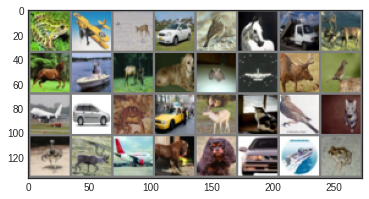

frog	plane	deer	automobile	bird	horse	truck	deer	horse	ship	deer	dog	frog	plane	deer	bird	plane	automobile	frog	automobile	deer	cat	bird	cat	bird	deer	plane	horse	dog	automobile	ship	frog	


In [ ]:
def imshow(img):
  img= img/2+0.5
  npimg=img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

dataiter= iter(train_loader)
images , labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print("".join('{}\t'.format(classes[labels[j]]) for j in range(32)))

모델 넣기 

In [10]:
class BasicBlock(nn.Module):
   def __init__(self, in_channels, out_channels, kernel_size=3):
       super(BasicBlock, self).__init__()


       # ❶ 합성곱층 정의
       self.c1 = nn.Conv2d(in_channels, out_channels, 
                           kernel_size=kernel_size, padding=1)
       self.c2 = nn.Conv2d(out_channels, out_channels, 
                           kernel_size=kernel_size, padding=1)

       self.downsample = nn.Conv2d(in_channels, out_channels, 
                                   kernel_size=1)
       
       # ❷ 배치 정규화층 정의
       self.bn1 = nn.BatchNorm2d(num_features=out_channels)
       self.bn2 = nn.BatchNorm2d(num_features=out_channels)

       self.relu = nn.ReLU()
   def forward(self, x):
       # ❸스킵 커넥션을 위해 초기 입력을 저장
       x_ = x

       x = self.c1(x)
       x = self.bn1(x)
       x = self.relu(x)
       x = self.c2(x)
       x = self.bn2(x)

       # ➍합성곱의 결과와 입력의 채널 수를 맞춤
       x_ = self.downsample(x_)

       # ➎합성곱층의 결과와 저장해놨던 입력값을 더해줌
       x += x_
       x = self.relu(x)

       return x


class ResNet(nn.Module):
   def __init__(self, num_classes=10):
       super(ResNet, self).__init__()


       # ❶ 기본 블록
       self.b1 = BasicBlock(in_channels=3, out_channels=64)
       self.b2 = BasicBlock(in_channels=64, out_channels=128)
       self.b3 = BasicBlock(in_channels=128, out_channels=256)


       # ❷ 풀링을 최댓값이 아닌 평균값으로
       self.pool = nn.AvgPool2d(kernel_size=2, stride=2) 

       # ❸ 분류기
       self.fc1 = nn.Linear(in_features=4096, out_features=2048)
       self.fc2 = nn.Linear(in_features=2048, out_features=512)
       self.fc3 = nn.Linear(in_features=512, out_features=num_classes)

       self.relu = nn.ReLU()
   def forward(self, x):
       # ❶ 기본 블록과 풀링층을 통과
       x = self.b1(x)
       x = self.pool(x)
       x = self.b2(x)
       x = self.pool(x)
       x = self.b3(x)
       x = self.pool(x)


       # ❷ 분류기의 입력으로 사용하기 위해 flatten
       x = torch.flatten(x, start_dim=1)

       # ❸ 분류기로 예측값 출력
       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)
       x = self.relu(x)
       x = self.fc3(x)

       return x



In [12]:

net = ResNet(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
total=0 
correct = 0

In [ ]:
for epoch in range(100):
  running_loss = 0.0

  for i, data in enumerate(train_loader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()
    outputs= net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 750 ==749:
      print("Epoch: {},Batch : {}, Loss:{}".format(epoch+1, i+1, running_loss/2000))
      running_loss = 0.0

  with torch.no_grad():
    val_loss = 0.0
    for k, data1 in enumerate(vaild_loader, 0):
      val_inputs, val_label = data1[0].to(device), data1[1].to(device)
      val_output = net(val_inputs)
      v_loss = criterion(val_output, val_label)
      val_loss += v_loss
  print("validation loss {}".format(val_loss))

  with torch.no_grad():
    for data in test_loader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs= net(images)
      _, predicted = torch.max(outputs.data,1)
      total +=labels.size(0)
      correct += (predicted == labels).sum().item()

  print(100* correct/total)
  total=0
  correct=0

Epoch: 1,Batch : 750, Loss:0.0001580630005701096
Epoch: 1,Batch : 1500, Loss:0.00019747135551733663
validation loss 108.27532958984375
39.42
Epoch: 2,Batch : 750, Loss:0.00021085437709916733
Epoch: 2,Batch : 1500, Loss:0.0001755561395229961
validation loss 110.05479431152344
39.55384615384615
Epoch: 3,Batch : 750, Loss:0.00012474185785504234
Epoch: 3,Batch : 1500, Loss:0.0001313459957705163
validation loss 109.6903076171875
39.672222222222224
Epoch: 4,Batch : 750, Loss:0.0001024538304654925
Epoch: 4,Batch : 1500, Loss:0.00010546980651361082
validation loss 111.9315185546875
39.7875
Epoch: 5,Batch : 750, Loss:0.00010669310632374618
Epoch: 5,Batch : 1500, Loss:9.889895496553436e-05
validation loss 112.82161712646484
39.90344827586207
Epoch: 6,Batch : 750, Loss:9.274426631691312e-05
Epoch: 6,Batch : 1500, Loss:8.81416231241019e-05
validation loss 111.41069030761719
40.015
Epoch: 7,Batch : 750, Loss:7.55731647700486e-05
Epoch: 7,Batch : 1500, Loss:7.577482866963692e-05
validation loss 111.

In [13]:
PATH = '/content/drive/MyDrive/share/trained_model/cifar_resnet.pth'


In [14]:
net = ResNet(num_classes=10).to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [17]:
correct = 0
total = 0
with torch.no_grad():
  for data in train_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs= net(images)
    _, predicted = torch.max(outputs.data,1)
    total +=labels.size(0)
    correct += (predicted == labels).sum().item()

print(100* correct/total)

100.0


In [15]:
correct = 0
total = 0
with torch.no_grad():
  for data in vaild_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs= net(images)
    _, predicted = torch.max(outputs.data,1)
    total +=labels.size(0)
    correct += (predicted == labels).sum().item()

print(100* correct/total)

86.49


In [18]:
correct = 0
total = 0
with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs= net(images)
    _, predicted = torch.max(outputs.data,1)
    total +=labels.size(0)
    correct += (predicted == labels).sum().item()

print(100* correct/total)

43.2
